<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

**Check relation betweeen dynamics and generalization.   Hypothesis to make: generalization can only be understood in level of joint dynamical system, there is a clear link between the two**

**Dynamnics determines generalization , not decoding , same decoding level can have very different dynamics , thus different generalization level.  Only when the dynamics of RNN forms object correspond to real relevant objects for game, the generalization can be good.   For instance , in a varying size game, you extend the size of game from 10 to 30, what will happen?  You can do a kind of dynamical programing , according to which wall you have seen and how many steps you have passed , you decide future action.    This can be achieved robustly by the dynamical system where fix points are correspond to walls**

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


## Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import pretrain
from pretrain import *

import navigation2
from navigation2 import *

import Nets 
from Nets import *

import sklearn
from sklearn.svm import SVC
from sklearn.manifold import Isomap
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate

import scipy
from scipy.spatial import distance
from scipy import signal

import dynamics 
from dynamics import * 


%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/tie/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

**What is the relation to head direction, this order kept in limit cycle**
**Could we define the order parameter for behaviour and link it to dynamics?**

# The GLM analysis of variance for different variables
The features include x, y, sensory,  action, last click memory , last twice click memory, the last twice click has a very strong contribution to features, but it inludes the last one click. In a sense, the integrated memory is not equalling to memroy 1 plus memory2 

In [117]:
# Put the stimulus memory(status) and action base for memory and navigation  
def Transform(States, Poss, Hiddens, Actions, Context, Values, history = False, size = 15):
    # last click state
    Borders = np.concatenate([State_transform(state, poss, size)[0] for state, poss in zip(States, Poss)])
    Status = np.concatenate([State_transform(state, poss, size)[1] for state, poss in zip(States, Poss)])
    Hiddens = np.concatenate(Hiddens)
    Poss = np.concatenate(Poss)
    Actions = np.concatenate(Actions)
    Context = np.concatenate(Context)
    # transform state to stim　
    States = np.concatenate(States)
    Values = np.concatenate(Values)
    # transform status to memory
    return Borders[Status>0], Poss[Status>0], Hiddens[Status>0], \
Actions[Status>0], Status[Status>0], Context[Status>0], Values[Status>0]
 


# histroy memory of two 
def history_summary(Status):
#     S = [p[0]  for s, p in zip(State, Poss)]
    M = np.zeros((len(Status), 2))
    m2 = 0
    for i, (s1, s2) in enumerate(zip(Status[:-1], Status[1:])): 
        # if next clicks changes, then store this click as a memory value registed in m2  
        if s2 != s1:
            m2 = s1
        # sore memory,  m0 as memory of stimulus, m1 as memory of second click    
        M[i+1, 0] = s2
        M[i+1, 1] = m2   
#         print (s1)
    return M  

# transform to time section
def Stage_transform(State):
    S = np.cumsum([np.sum(s1 != s2) for (s1, s2) in zip(State[:-1], State[1:])] + [1]) 
    return S

In [118]:
# transform to space section
def wall_detection(pos, size):
    if pos[0] == 2:
        Stim = 1
    elif pos[0] == 2 + size - 1:
        Stim = 2
    elif pos[1] == 2:
        Stim = 3
    elif pos[1] == 2 + size - 1:
        Stim = 4
    else:
        Stim = 0 
    return Stim 
# for the memory feature, a Msimple one is just the last click, a most complicate one should be click sequence     
def State_transform(State, Poss, size):
#     S = [p[0]  for s, p in zip(State, Poss)]
    S = [wall_detection(pos, size) for pos in Poss]
    Status = []
    s1 = 0
    for s in S: 
        if s != 0: 
            s1 = s
#         print (s1)
        Status.append(s1)
    return S, Status
# histroy memory of two 
def history_summary(Status):
#     S = [p[0]  for s, p in zip(State, Poss)]
    M = np.zeros((len(Status), 2))
    m2 = 0
    for i, (s1, s2) in enumerate(zip(Status[:-1], Status[1:])): 
        # if next clicks changes, then store this click as a memory value registed in m2  
        if s2 != s1:
            m2 = s1
        # sore memory,  m0 as memory of stimulus, m1 as memory of second click    
        M[i+1, 0] = s2
        M[i+1, 1] = m2   
#         print (s1)
    return M

In [119]:
def Feature_preprocessing(States, Poss, Hiddens, Actions, Context, Values, size = 15):
    States, Poss, Hiddens, Actions, Status, Context, Values = Transform(States, Poss, Hiddens, \
                                                                        Actions, Context, Values)
    x =  Hiddens[:, :512]
    z = (x - np.min(x))/(np.max(x) - np.min(x))
    y = np.log(z/(1-z + 1e-3) + 1e-3)
    A = np.array([np.eye(4)[a] for a in Actions]).reshape(-1, 4)
    Y = np.array([(y - size/2.) for y in Poss[:, 0] -2]).reshape(-1, 1)
    X = np.array([(x - size/2.) for x in Poss[:, 1] - 2]).reshape(-1, 1)
    M = np.array([np.eye(5)[s] for s in Status]).reshape(-1, 5)
    S = np.array([np.eye(5)[s] for s in States]).reshape(-1, 5)
#     S = np.array(States).reshape(-1, 9)
    C = np.array(Context).reshape(-1, 1)
    # S_wall = np.array([np.eye(27)[s] for s in Stim_wall]).reshape(-1, 27)
    Features = np.concatenate((A, Y, X, M, S, C), axis = 1)
    Features_A = np.concatenate((Y, X, M, S, C), axis = 1)
    Features_Y = np.concatenate((A, X, M, S, C), axis = 1)
    Features_X = np.concatenate((A, Y, M, S, C), axis = 1)
    Features_M = np.concatenate((A, Y, X, S, C), axis = 1)
    Features_S = np.concatenate((A, Y, X, M, C), axis = 1)
    Features_C = np.concatenate((A, Y, X, M, S), axis = 1)
    return y, Features, Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C, Values
# State_transform()

In [120]:
# record sessions 100 for 2 different context, record the relevant variables 
def Data_record(weight, k_action = 1, epsilon = 0, size = 15, T = 500, seed_num = 1e3):
    PC_traces = []
    Hiddens = []
    Poss = []
    Actions = []
    States = []
    Context = []
    Values = []
    for i in range(T):
        torch.manual_seed(np.random.randint(seed_num))
        hidden0 = torch.randn(1, 512)
        c  = np.random.randint(2)
        start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
        game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 0 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, discount = 0.9, alpha = 1
                           ,lam = 0)
        game.net.load_state_dict(torch.load(weight))
        game.net.k_action = k_action 
        grid = game.grid.grid.copy()
        Pos, hidden, dh, Action, State, values, reward = trajectory(game, start, reward_control = c, size = size, \
                                                                  test = 0, limit_set = 8, init_hidden = False, hidden = hidden0, epsilon = epsilon, reward = True)
        Hiddens.append(hidden)
        Poss.append(Pos[1:])
        Actions.append(Action)
        States.append(State)
        Context.append(c * np.ones(len(State)))
        Values.append(values)
    return States, Poss, Hiddens, Actions, Context, Values

## Echo Net

# Variance
More variance covered by low D variables, corresponding to low D representation shown by PCA 

In [121]:
# record sessions 100 for 2 different context, record the relevant variables 
weight ='weights2/rnn_1515tanh512_checkpoint300_0_5'
States1, Poss1, Hiddens1, Actions1, Context1, Values1 = Data_record(weight, T = 1000)
y, Features, Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C, Values1 = Feature_preprocessing(States1, Poss1, Hiddens1, Actions1,\
                                                                                                           Context1, Values1)
clf0 = Lasso(alpha = 1e-2)
clf0.fit(Features_A, y)
cv_scores_all = cross_validate(clf0, Features, y, cv = 5, scoring=('r2'), return_train_score = True)
print ('total variance', np.mean(cv_scores_all['train_score']), np.mean(cv_scores_all['test_score']))
importances = []
importances_std = []
for i, feature in enumerate([Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C]):
    clf = Lasso(alpha = 1e-2)
    cv_scores = cross_validate(clf, feature, y, cv = 5, scoring=('r2'), return_train_score = True)
    print ('total variance', np.mean(cv_scores_all['train_score'] -  cv_scores['train_score']), \
           np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
    importances.append(np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
    importances_std.append(np.std(cv_scores_all['test_score'] - cv_scores['test_score']))

total variance 0.19699601003309092 0.19138872856537942
total variance 0.03685350239950994 0.03658431167353781
total variance 0.018545208015745766 0.018188594576731408
total variance 0.03592005984599454 0.03498198686337241
total variance 0.006659847681632786 0.006158765631426999
total variance 0.01436981433928466 0.014356555266489362
total variance 0.014207202728388551 0.014147252948814904


([<matplotlib.axis.YTick at 0x7fee2f104400>,
 <a list of 2 Text yticklabel objects>)

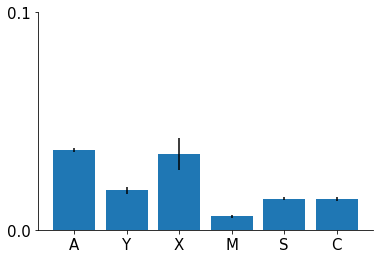

In [122]:
np.save('importance_pos', importances)
np.save('importance_pos_std', importances_std)

# 009
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
imp = np.load('importance_pos.npy')
imp_std = np.load('importance_pos_std.npy')
plt.bar(np.arange(6), height = imp, yerr = imp_std)
plt.xticks([0, 1, 2, 3, 4, 5], ['A', 'Y', 'X', 'M', 'S', 'C'], size = 15)
plt.yticks([0, 0.1], size = 15)

In [16]:
# record sessions 100 for 2 different context, record the relevant variables 
weight ='weights2/rnn_1515tanh512_checkpoint300_0_5'
States1, Poss1, Hiddens1, Actions1, Context1 = Data_record(weight, T = 100, epsilon = 1)
y, Features, Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C = Feature_preprocessing(States1, Poss1, Hiddens1, Actions1,\
                                                                                                           Context1)
clf = Lasso(alpha = 1e-3)
cv_scores_all = cross_validate(clf, Features, y, cv = 5, scoring=('r2'), return_train_score = True)
print ('total variance', np.mean(cv_scores_all['train_score']), np.mean(cv_scores_all['test_score']))
importances = []
importances_std = []
for i, feature in enumerate([Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C]):
    clf = Lasso(alpha = 1e-3)
    cv_scores = cross_validate(clf, feature, y, cv = 5, scoring=('r2'), return_train_score = True)
    print ('total variance', np.mean(cv_scores_all['train_score'] -  cv_scores['train_score']), \
           np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
    importances.append(np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
    importances_std.append(np.std(cv_scores_all['test_score'] - cv_scores['test_score']))

total variance 0.4203386298637537 0.4003893429038
total variance 0.004446462476526391 0.004314739758487318
total variance 0.05695286787772624 0.055289148518798945
total variance 0.06209497705731639 0.06268480480353186
total variance 0.03622384512776057 0.03283432304397101
total variance 0.027929493174714538 0.028063619698886755
total variance 0.03054550203971721 0.030158172404803497


In [10]:
# record sessions 100 for 2 different context, record the relevant variables 
Importance = []
Importance_std = []
for trial in range(6, 10):
    weight ='weights2/rnn_1515tanh512_checkpoint300_0_{}'.format(trial)
    States1, Poss1, Hiddens1, Actions1, Context1 = Data_record(weight)
    y, Features, Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C = Feature_preprocessing(States1, Poss1, Hiddens1, Actions1,\
                                                                                                               Context1)
    clf = Lasso(alpha = 1e-3)
    cv_scores_all = cross_validate(clf, Features, y, cv = 5, scoring=('r2'), return_train_score = True)
    print ('total variance', np.mean(cv_scores_all['train_score']), np.mean(cv_scores_all['test_score']))
    importances = []
    importances_std = []
    for i, feature in enumerate([Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C]):
        clf = Lasso(alpha = 1e-3)
        cv_scores = cross_validate(clf, feature, y, cv = 5, scoring=('r2'), return_train_score = True)
        print (trial, 'total variance', np.mean(cv_scores_all['train_score'] -  cv_scores['train_score']), \
               np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
        importances.append(np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
        importances_std.append(np.std(cv_scores_all['test_score'] - cv_scores['test_score']))
    Importance.append(importances)
    Importance_std.append(importances_std)

total variance 0.263835760615 0.246202651582
6 total variance 0.0330993475463 0.0330267717793
6 total variance 0.0166299845228 0.0115547615138
6 total variance 0.0342568915644 0.029740167261
6 total variance 0.086325525197 0.0837202552752
6 total variance 0.0238203440926 0.023532200563
6 total variance 0.0172765100837 0.01720197913
total variance 0.259006366327 0.24263884189
7 total variance 0.0344710416859 0.0344546439895
7 total variance 0.0166122376176 0.0123312409496
7 total variance 0.0288617542136 0.0245406637203
7 total variance 0.0777833917927 0.0767762510815
7 total variance 0.0223652614062 0.022109506729
7 total variance 0.0250069140333 0.0255848284447
total variance 0.245831691012 0.228471145487
8 total variance 0.0329786182708 0.0331592687301
8 total variance 0.0172987044385 0.0124891656321
8 total variance 0.0295301043236 0.024334748635
8 total variance 0.065817113178 0.0637173803546
8 total variance 0.0221273835384 0.0218954531737
8 total variance 0.0245831083966 0.024711

In [6]:
np.save('importance_pos_early', importances)
np.save('importance_pos_early_std', importances_std)

([<matplotlib.axis.YTick at 0x7fc3a58d0940>,
 <a list of 7 Text yticklabel objects>)

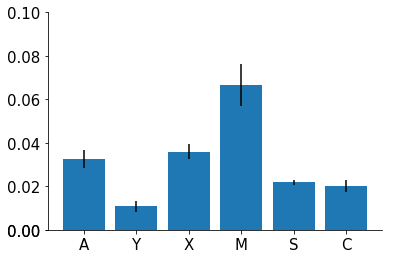

In [7]:
# 009
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
imp = np.load('importance_pos_early.npy')
imp_std = np.load('importance_pos_early_std.npy')
plt.bar(np.arange(6), height = imp, yerr = imp_std)
plt.xticks([0, 1, 2, 3, 4, 5], ['A', 'Y', 'X', 'M', 'S', 'C'], size = 15)
plt.yticks([0, 0, 0.02, 0.04, 0.06, 0.08, 0.1], size = 15)

In [4]:
# record sessions 100 for 2 different context, record the relevant variables 
Importance = []
Importance_std = []
for trial in range(3):
    weight ='weights2/rnn_1515tanh512_checkpoint300_0_{}'.format(trial)
    States1, Poss1, Hiddens1, Actions1, Context1 = Data_record(weight)
    y, Features, Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C = Feature_preprocessing(States1, Poss1, Hiddens1, Actions1,\
                                                                                                               Context1)
    clf = Lasso(alpha = 1e-3)
    cv_scores_all = cross_validate(clf, Features, y, cv = 5, scoring=('r2'), return_train_score = True)
    print ('total variance', np.mean(cv_scores_all['train_score']), np.mean(cv_scores_all['test_score']))
    importances = []
    importances_std = []
    for i, feature in enumerate([Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C]):
        clf = Lasso(alpha = 1e-3)
        cv_scores = cross_validate(clf, feature, y, cv = 5, scoring=('r2'), return_train_score = True)
        print (trial, 'total variance', np.mean(cv_scores_all['train_score'] -  cv_scores['train_score']), \
               np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
        importances.append(np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
        importances_std.append(np.std(cv_scores_all['test_score'] - cv_scores['test_score']))
    Importance.append(importances)
    Importance_std.append(importances_std)

total variance 0.327173256837 0.315465829693
0 total variance 0.0200030498896 0.0199374490446
0 total variance 0.0434335523015 0.0407579854156
0 total variance 0.0423444327337 0.0392834183068
0 total variance 0.0819554186831 0.0817873473891
0 total variance 0.0209799443483 0.0209045771207
0 total variance 0.0193840080559 0.0194643506655
total variance 0.274697116699 0.259807793637
1 total variance 0.023817539858 0.0234344440381
1 total variance 0.0141232696955 0.0104529531129
1 total variance 0.0535874556938 0.0503814058933
1 total variance 0.0841223391817 0.0824486868924
1 total variance 0.0241352803477 0.0239896130271
1 total variance 0.021315470648 0.0214167850055
total variance 0.277993900908 0.259667266125
2 total variance 0.0238230959259 0.023627762112
2 total variance 0.0145787893602 0.00974019379151
2 total variance 0.0375416887193 0.0342517891959
2 total variance 0.0880396702831 0.0871252232568
2 total variance 0.0224758165583 0.0221920932845
2 total variance 0.0213754943196 0

In [9]:
# record sessions 100 for 2 different context, record the relevant variables 
# record sessions 100 for 2 different context, record the relevant variables 
weight ='weights_fix/weights1/rnn_1515tanh512_checkpoint0_2_9'
States1, Poss1, Hiddens1, Actions1, Context1 = Data_record(weight)
y, Features, Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C = Feature_preprocessing(States1, Poss1, Hiddens1, Actions1,\
                                                                                                           Context1)
clf = Lasso(alpha = 1e-3)
cv_scores_all = cross_validate(clf, Features, y, cv = 5, scoring=('r2'), return_train_score = True)
print ('total variance', np.mean(cv_scores_all['train_score']), np.mean(cv_scores_all['test_score']))
importances = []
importances_std = []
for i, feature in enumerate([Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C]):
    clf = Lasso(alpha = 1e-3)
    cv_scores = cross_validate(clf, feature, y, cv = 5, scoring=('r2'), return_train_score = True)
    print ('total variance', np.mean(cv_scores_all['train_score'] -  cv_scores['train_score']), \
           np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
    importances.append(np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
    importances_std.append(np.std(cv_scores_all['test_score'] - cv_scores['test_score']))

total variance 0.3900987683273135 0.3734116620426762
total variance 0.007412913894201567 0.006524081372758017
total variance 0.00871587652987571 0.003744449241153458
total variance 0.019627994153965954 0.017682182678894633
total variance 0.03783858737817891 0.03711714335277766
total variance 0.05536294711007096 0.056180287701844675
total variance 0.008143078767178147 0.007955799192881752


In [10]:
np.save('importance_echo', importances)
np.save('importance_echo_std', importances_std)

([<matplotlib.axis.YTick at 0x7f96a0e64128>,
 <a list of 2 Text yticklabel objects>)

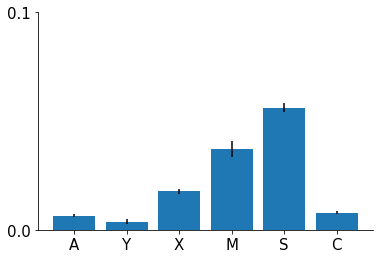

In [30]:
# 009
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
imp = np.load('importance_echo.npy')
imp_std = np.load('importance_echo_std.npy')
plt.bar(np.arange(6), height = imp, yerr = imp_std)
plt.xticks([0, 1, 2, 3, 4, 5], ['A', 'Y', 'X', 'M', 'S', 'C'], size = 15)
plt.yticks([0, 0.1], size = 15)
# plt.yscale('log')

## Pretrain late

In [36]:
weight0 ='weights_cpu1/rnn_1515tanh512_checkpoint39'
States1, Poss1, Hiddens1, Actions1, Context1 = Data_record(weight, epsilon=0)
y, Features, Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C = Feature_preprocessing(States1, Poss1, Hiddens1, Actions1,\
                                                                                                           Context1)
clf = Lasso(alpha = 1e-3)
cv_scores_all = cross_validate(clf, Features, y, cv = 5, scoring=('r2'), return_train_score = True)
print ('total variance', np.mean(cv_scores_all['train_score']), np.mean(cv_scores_all['test_score']))
importances = []
importances_std = []
for i, feature in enumerate([Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C]):
    clf = Lasso(alpha = 1e-3)
    cv_scores = cross_validate(clf, feature, y, cv = 5, scoring=('r2'), return_train_score = True)
    print ('total variance', np.mean(cv_scores_all['train_score'] -  cv_scores['train_score']), \
           np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
    importances.append(np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
    importances_std.append(np.std(cv_scores_all['test_score'] - cv_scores['test_score']))

total variance 0.48573512471582847 0.4760540102841452
total variance 0.006462179396043999 0.005937664058737535
total variance 0.017844784688296467 0.01568026495057735
total variance 0.0137360988308718 0.012141880430233131
total variance 0.19824898015596476 0.20164431620665604
total variance 0.07569310612763996 0.07648974476504691
total variance 0.02935466421408215 0.02974562872647508


In [33]:
weight0 ='weights_cpu1/rnn_1515tanh512_checkpoint39'
States1, Poss1, Hiddens1, Actions1, Context1 = Data_record(weight, epsilon=1)
y, Features, Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C = Feature_preprocessing(States1, Poss1, Hiddens1, Actions1,\
                                                                                                           Context1)
clf = Lasso(alpha = 1e-3)
cv_scores_all = cross_validate(clf, Features, y, cv = 5, scoring=('r2'), return_train_score = True)
print ('total variance', np.mean(cv_scores_all['train_score']), np.mean(cv_scores_all['test_score']))
importances = []
importances_std = []
for i, feature in enumerate([Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C]):
    clf = Lasso(alpha = 1e-3)
    cv_scores = cross_validate(clf, feature, y, cv = 5, scoring=('r2'), return_train_score = True)
    print ('total variance', np.mean(cv_scores_all['train_score'] -  cv_scores['train_score']), \
           np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
    importances.append(np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
    importances_std.append(np.std(cv_scores_all['test_score'] - cv_scores['test_score']))

total variance 0.6199333086024569 0.616098696369416
total variance 0.0002084292386299813 0.00017799360267927166
total variance 0.005637816634458548 0.005200699670664855
total variance 0.003856031573089469 0.00349963747524884
total variance 0.24456735652920597 0.25001901446643426
total variance 0.08419576398176423 0.08454351574639349
total variance 0.03750032346686545 0.03856816138832022


In [34]:
np.save('importance_39_ran', importances)
np.save('importance_39_ran_std', importances_std)

([<matplotlib.axis.YTick at 0x7f96a19c2f98>,
 <a list of 7 Text yticklabel objects>)

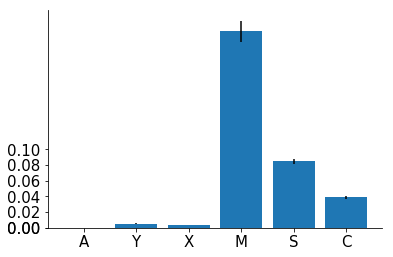

In [35]:
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
imp = np.load('importance_39_ran.npy')
imp_std = np.load('importance_39_ran_std.npy')
plt.bar(np.arange(6), height = imp, yerr = imp_std)
plt.xticks([0, 1, 2, 3, 4, 5], ['A', 'Y', 'X', 'M', 'S', 'C'], size = 15)
plt.yticks([0, 0, 0.02, 0.04, 0.06, 0.08, 0.1], size = 15)

In [15]:
# record sessions 100 for 2 different context, record the relevant variables 
weight ='weights_fix/weights1/rnn_1515tanh512_checkpoint39_2_9'
States1, Poss1, Hiddens1, Actions1, Context1 = Data_record(weight)
y, Features, Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C = Feature_preprocessing(States1, Poss1, Hiddens1, Actions1,\
                                                                                                           Context1)
clf = Lasso(alpha = 1e-3)
cv_scores_all = cross_validate(clf, Features, y, cv = 5, scoring=('r2'), return_train_score = True)
print ('total variance', np.mean(cv_scores_all['train_score']), np.mean(cv_scores_all['test_score']))
importances = []
importances_std = []
for i, feature in enumerate([Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C]):
    clf = Lasso(alpha = 1e-3)
    cv_scores = cross_validate(clf, feature, y, cv = 5, scoring=('r2'), return_train_score = True)
    print ('total variance', np.mean(cv_scores_all['train_score'] -  cv_scores['train_score']), \
           np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
    importances.append(np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
    importances_std.append(np.std(cv_scores_all['test_score'] - cv_scores['test_score']))

total variance 0.31721267690645655 0.2942473889825306
total variance 0.027002631190721216 0.026514853996747596
total variance 0.012149880899032994 0.006382254638992124
total variance 0.061483550335101576 0.05719279277966778
total variance 0.04440506871493353 0.043728727474883745
total variance 0.02152842744217217 0.021326007147972975
total variance 0.02176225992520271 0.02195953498579638


In [16]:
np.save('importance_39_early', importances)
np.save('importance_39_early_std', importances_std)

([<matplotlib.axis.YTick at 0x7f96a21ab320>,
 <a list of 7 Text yticklabel objects>)

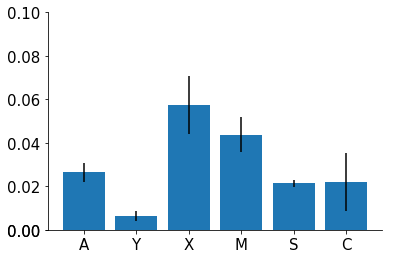

In [17]:
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
imp = np.load('importance_39_early.npy')
imp_std = np.load('importance_39_early_std.npy')
plt.bar(np.arange(6), height = imp, yerr = imp_std)
plt.xticks([0, 1, 2, 3, 4, 5], ['A', 'Y', 'X', 'M', 'S', 'C'], size = 15)
plt.yticks([0, 0, 0.02, 0.04, 0.06, 0.08, 0.1], size = 15)

In [6]:
# record sessions 100 for 2 different context, record the relevant variables 
weight ='weights_fix/weights1/rnn_1515tanh512_checkpoint39_2_9'
States1, Poss1, Hiddens1, Actions1, Context1 = Data_record(weight)
y, Features, Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C = Feature_preprocessing(States1, Poss1, Hiddens1, Actions1,\
                                                                                                           Context1)
clf = Lasso(alpha = 1e-3)
cv_scores_all = cross_validate(clf, Features, y, cv = 5, scoring=('r2'), return_train_score = True)
print ('total variance', np.mean(cv_scores_all['train_score']), np.mean(cv_scores_all['test_score']))
importances = []
importances_std = []
for i, feature in enumerate([Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C]):
    clf = Lasso(alpha = 1e-3)
    cv_scores = cross_validate(clf, feature, y, cv = 5, scoring=('r2'), return_train_score = True)
    print ('total variance', np.mean(cv_scores_all['train_score'] -  cv_scores['train_score']), \
           np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
    importances.append(np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
    importances_std.append(np.std(cv_scores_all['test_score'] - cv_scores['test_score']))

total variance 0.3293548604588767 0.302178242437437
total variance 0.023281584548012914 0.02268872299490212
total variance 0.010922114970701613 0.006340058649743708
total variance 0.06191556487930637 0.058104443962850395
total variance 0.05568991566761493 0.05317901535938727
total variance 0.021861688208954243 0.02155693360398636
total variance 0.028074375152168464 0.027763299692792842


In [7]:
np.save('importance_39', importances)
np.save('importance_39_std', importances_std)

([<matplotlib.axis.YTick at 0x7f96a0da35c0>,
 <a list of 2 Text yticklabel objects>)

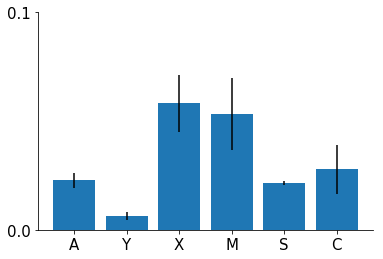

In [31]:
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
imp = np.load('importance_39.npy')
imp_std = np.load('importance_39_std.npy')
plt.bar(np.arange(6), height = imp, yerr = imp_std)
plt.xticks([0, 1, 2, 3, 4, 5], ['A', 'Y', 'X', 'M', 'S', 'C'], size = 15)
plt.yticks([0, 0.1], size = 15)

plt.hist(np.array(entropy1))
plt.figure()
plt.hist(np.array(entropy2))

## Pretrain Net2

In [20]:
weight = 'weights_fix_pre2/weights1/rnn_1515tanh512_checkpoint49_0_9'
# loadweight(weight_load = 'weights_cpu8/rnn_1515tanh512_checkpoint{}'.format(trial))
States1, Poss1, Hiddens1, Actions1, Context1 = Data_record(weight)
y, Features, Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C = Feature_preprocessing(States1, Poss1, Hiddens1, Actions1,\
                                                                                                           Context1)
clf = Lasso(alpha = 1e-3)
cv_scores_all = cross_validate(clf, Features, y, cv = 5, scoring=('r2'), return_train_score = True)
print ('total variance', np.mean(cv_scores_all['train_score']), np.mean(cv_scores_all['test_score']))
importances = []
importances_std = []
for i, feature in enumerate([Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C]):
    clf = Lasso(alpha = 1e-3)
    cv_scores = cross_validate(clf, feature, y, cv = 5, scoring=('r2'), return_train_score = True)
    print ('total variance', np.mean(cv_scores_all['train_score'] -  cv_scores['train_score']), \
           np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
    importances.append(np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
    importances_std.append(np.std(cv_scores_all['test_score'] - cv_scores['test_score']))

total variance 0.48801937512183163 0.47862559380930403
total variance 0.0054364210886023836 0.0049760003762125745
total variance 0.017238618699956965 0.015518189510648095
total variance 0.013729599098896428 0.012327570184542547
total variance 0.2047673708895889 0.21098770605324338
total variance 0.07701052149262691 0.07779149437159348
total variance 0.028704327767368153 0.02912998770702563


In [22]:
np.save('importance_49', importances)
np.save('importance_49_std', importances_std)

([<matplotlib.axis.YTick at 0x7f96a0f92710>,
 <a list of 2 Text yticklabel objects>)

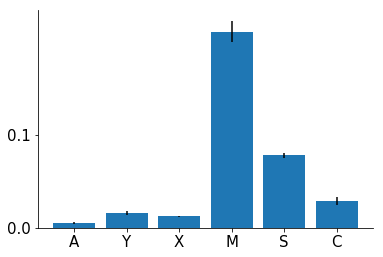

In [43]:
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
imp = np.load('importance_49.npy')
imp_std = np.load('importance_49_std.npy')
plt.bar(np.arange(6), height = imp, yerr = imp_std)
plt.xticks([0, 1, 2, 3, 4, 5], ['A', 'Y', 'X', 'M', 'S', 'C'], size = 15)
plt.yticks([0, 0.1], size = 15)
# plt.ylim(0, 0.1)

## Build a SVM decoder 

### position

In [18]:
# increasing action 10 times will increase decoding efficientcy by 10 %
weight ='weights_cpu/rnn_1515tanh512_checkpoint0'
# # change weights
States, Poss, Hiddens, Actions, Context = Data_record(weight, k_action = 1, T = 500, seed_num = 1e6, epsilon = 1, size = 15)
States, Poss, Hiddens, Actions, Status, Context = Transform(States, Poss, Hiddens, Actions, Context)
X = np.array(Hiddens[Status>1])
Y = Status[Status>1]
score0 = cross_validate(model, X,Y, cv = 5)

In [14]:
# increasing action 10 times will increase decoding efficientcy by 10 %
weight ='weights_cpu_pre2/rnn_1515tanh512_checkpoint0'
Pretest = PretrainTest(weight, holes = 0, inputs_type = (0, 0))
Pretest.loadweight(weight)
States, Poss, Hiddens, Actions, Context = Data_record(weight, k_action = 1, T = 500, seed_num = 1e6, epsilon = 1, size = 15)
States, Poss, Hiddens, Actions, Status, Context = Transform(States, Poss, Hiddens, Actions, Context)
X = np.array(Hiddens[Status>1])
Y = Status[Status>1]
score = cross_validate(model, X,Y, cv = 5)

0.9782879818594105


In [19]:
# increasing action 10 times will increase decoding efficientcy by 10 %

weight ='weights_cpu/rnn_1515tanh512_checkpoint300'
States, Poss, Hiddens, Actions, Context = Data_record(weight, k_action = 1, T = 500, seed_num = 1e6, epsilon = 1, size = 15)
States, Poss, Hiddens, Actions, Status, Context = Transform(States, Poss, Hiddens, Actions, Context)
X = np.array(Hiddens[Status>1])
Y = Status[Status>1]
score_pos = cross_validate(model, X,Y, cv = 5)

In [20]:
test_echo = score0['test_score']
test_pre2 = score['test_score']
test_pos = score_pos['test_score']

([<matplotlib.axis.YTick at 0x7ff40730c588>,
 <a list of 3 Text yticklabel objects>)

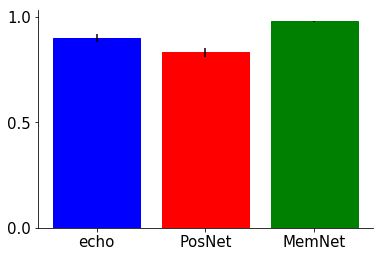

In [32]:
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

barlist = plt.bar(np.arange(3), height = [np.mean(test_echo), np.mean(test_pos), np.mean(test_pre2)], yerr =  [np.std(test_echo), np.std(test_pos), np.std(test_pre2)])
barlist[0].set_color('b')
barlist[1].set_color('r')
barlist[2].set_color('g')
plt.xticks([0, 1, 2], ['echo', 'PosNet', 'MemNet'], size = 15)
plt.yticks([0, 0.5, 1], size = 15)

In [6]:
np.abs(np.array(y_test)//15 - model.predict(X_test)//15).mean() + np.abs(np.array(y_test)%15 -  model.predict(X_test)%15).mean()

0.07706672412554766

In [11]:
# increasing action 10 times will increase decoding efficientcy by 10 %
weight ='weights_cpu/rnn_1515tanh512_checkpoint0'
# # change weights
States, Poss, Hiddens, Actions, Context = Data_record(weight, k_action = 1, T = 500, seed_num = 1e6, epsilon = 0.5, size  =15)
States, Poss, Hiddens, Actions, Status, Context = Transform(States, Poss, Hiddens, Actions, Context)
X = np.array(Hiddens[Status>1])
Y = [p[0]/15 for p in Poss[Status>1]]
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.9, random_state=30)
 
model = sklearn.linear_model.Lasso(alpha=1e-3)
model.fit(X_train, y_train)
print (r2_score(y_test, model.predict(X_test)))

0.6447786721873939


In [12]:
# increasing action 10 times will increase decoding efficientcy by 10 %
weight ='weights_cpu/rnn_1515tanh512_checkpoint300'
# # change weights
States, Poss, Hiddens, Actions, Context = Data_record(weight, k_action = 1, T = 500, seed_num = 1e6, epsilon = 0.5, size  =15)
States, Poss, Hiddens, Actions, Status, Context = Transform(States, Poss, Hiddens, Actions, Context)
X = np.array(Hiddens[Status>1])
Y = [p[0]/15 for p in Poss[Status>1]]
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.9, random_state=30)
 
model = sklearn.linear_model.Lasso(alpha=1e-3)
model.fit(X_train, y_train)
print (r2_score(y_test, model.predict(X_test)))

0.6992427838530717


In [57]:
np.abs(np.array(y_test)//15 - model.predict(X_test)//15).mean() + np.abs(np.array(y_test)%15 -  model.predict(X_test)%15).mean()

0.13342626842487867

In [3]:
# increasing action 10 times will increase decoding efficientcy by 10 %
weight ='weights_fix/weights1/rnn_1515tanh512_checkpoint39_0_9'
# # change weights
States, Poss, Hiddens, Actions, Context = Data_record(weight, k_action = 1, T = 800, seed_num = 1e6, epsilon = 1)
States, Poss, Hiddens, Actions, Status, Context = Transform(States, Poss, Hiddens, Actions, Context)
X = np.array(Hiddens[Status>0][:-2])
Y = [p[1] + p[0] * 15 for p in Poss[Status>0][2:]]
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.5, random_state=30)
 
gammas = [1e-2]
for gamma in gammas:
    model1 = sklearn.svm.SVC(C = 1e5, gamma = gamma, kernel = 'linear')
    model1.fit(X_train, y_train)
    print (f1_score(y_test, model1.predict(X_test), average = 'micro'))

0.039778307843412374


In [5]:
np.abs(np.array(y_test[:100])//15 - model1.predict(X_test[:100])//15).mean() + np.abs(np.array(y_test[:100])%15 -  model1.predict(X_test[:100])%15).mean()

5.5

In [8]:
# increasing action 10 times will increase decoding efficientcy by 10 %
weight ='weights_fix/weights1/rnn_1515tanh512_checkpoint39_0_9'
# # change weights
States, Poss, Hiddens, Actions, Context = Data_record(weight, k_action = 1, T = 800, seed_num = 1e6, epsilon = 1)
States, Poss, Hiddens, Actions, Status, Context = Transform(States, Poss, Hiddens, Actions, Context)
X = np.array(Hiddens[Status>0])
Y = [p[1] + p[0] * 15 for p in Poss[Status>0]]
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.5, random_state=30)
 
gammas = [1e-2]
for gamma in gammas:
    model1 = sklearn.svm.SVC(C = 1e5, gamma = gamma, kernel = 'linear')
    model1.fit(X_train, y_train)
    print (f1_score(y_test, model1.predict(X_test), average = 'micro'))

0.0569691829233814


In [10]:
np.abs(np.array(y_test[:100])//15 - model1.predict(X_test[:100])//15).mean() + np.abs(np.array(y_test[:100])%15 -  model1.predict(X_test[:100])%15).mean()

3.45

In [17]:
weight ='weights_fix_pre2/weights1/rnn_1515tanh512_checkpoint49_1_9'
# # change weights
States, Poss, Hiddens, Actions, Context = Data_record(weight, k_action = 1, epsilon = 1, T = 800, seed_num = 1e6)
States, Poss, Hiddens, Actions, Status, Context = Transform(States, Poss, Hiddens, Actions, Context)
X = np.array(Hiddens[Status>0])
Y = [p[1] + p[0] * 15 for p in Poss[Status>0]]
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.5, random_state=30)
 
gammas = [1e-2]
for gamma in gammas:
    model1 = sklearn.svm.SVC(C = 1e5, gamma = gamma, kernel = 'linear')
    model1.fit(X_train, y_train)
    print (f1_score(y_test, model1.predict(X_test), average = 'micro'))

0.06090251464002756


In [18]:
np.abs(np.array(y_test[:100])//15 - model1.predict(X_test[:100])//15).mean() + np.abs(np.array(y_test[:100])%15 -  model1.predict(X_test[:100])%15).mean()

4.43

In [ ]:
### memory 

In [85]:
weight ='weights_fix/weights1/rnn_1515tanh512_checkpoint0_0_9'
# # change weights
States, Poss, Hiddens, Actions, Context = Data_record(weight, k_action = 1, epsilon = 1, T = 800, seed_num = 1e6, size = 30)
States, Poss, Hiddens, Actions, Status, Context = Transform(States, Poss, Hiddens, Actions, Context, size = 15)
X = np.array(Hiddens[Status>0])
Y = Status[Status>0]
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.5, random_state=30)
 
model = sklearn.linear_model.LogisticRegression(C = 1e5)
model.fit(X_train, y_train)
print (f1_score(y_test, model.predict(X_test), average = 'micro'))

0.6783576308190717


In [87]:
weight ='weights_fix/weights1/rnn_1515tanh512_checkpoint39_0_9'
# # change weights
States, Poss, Hiddens, Actions, Context = Data_record(weight, k_action = 1, epsilon = 1, T = 800, seed_num = 1e6, size = 30)
States, Poss, Hiddens, Actions, Status, Context = Transform(States, Poss, Hiddens, Actions, Context, size = 15)
X = np.array(Hiddens[Status>0])
Y = Status[Status>0]
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.5, random_state=30)
 
model = sklearn.linear_model.LogisticRegression(C = 1e5)
model.fit(X_train, y_train)
print (f1_score(y_test, model.predict(X_test), average = 'micro'))

0.630360236150882


In [10]:
weight ='weights_fix_pre2/weights1/rnn_1515tanh512_checkpoint49_1_9'
# # change weights
States, Poss, Hiddens, Actions, Context = Data_record(weight, k_action = 1, epsilon = 1, T = 800, seed_num = 1e6, size = 50)
States, Poss, Hiddens, Actions, Status, Context = Transform(States, Poss, Hiddens, Actions, Context, size = 15)
X = np.array(Hiddens[Status>0])
Y = Status[Status>0]
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.5, random_state=30)
 
model = sklearn.linear_model.LogisticRegression(C = 1e5)
model.fit(X_train, y_train)
print (f1_score(y_test, model.predict(X_test), average = 'micro'))

FileNotFoundError: [Errno 2] No such file or directory: 'weights_fix_pre2/weights1/rnn_1515tanh512_checkpoint49_1_9'

In [ ]:
### History 

In [3]:
weight ='weights_fix/weights1/rnn_1515tanh512_checkpoint0_0_9'
# # change weights
States, Poss, Hiddens, Actions, Context = Data_record(weight, epsilon = 1, k_action = 1, T = 400, seed_num = 1e6)
States, Poss, Hiddens, Actions, Status, Context, Memory = Transform(States, Poss, Hiddens, Actions, Context, history = True)

Mem = np.array([mem[1] + 4 * mem[0] for mem in Memory])

X = np.array(Hiddens[Status>0])
Y = Mem[Status>0]
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.5, random_state=30)
 
gammas = [1e-2]
for gamma in gammas:
    model1 = sklearn.svm.SVC(C = 1e5, gamma = gamma, kernel = 'linear')
    model1.fit(X_train, y_train)
    print (f1_score(y_test, model1.predict(X_test), average = 'micro'))

0.8517792098627066


In [4]:
weight ='weights_fix/weights1/rnn_1515tanh512_checkpoint39_0_9'
# # change weights
States, Poss, Hiddens, Actions, Context = Data_record(weight, epsilon = 1, k_action = 1, T = 400, seed_num = 1e6)
States, Poss, Hiddens, Actions, Status, Context, Memory = Transform(States, Poss, Hiddens, Actions, Context, history = True)

Mem = np.array([mem[1] + 4 * mem[0] for mem in Memory])

X = np.array(Hiddens[Status>0])
Y = Mem[Status>0]
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.5, random_state=30)
 
gammas = [1e-2]
for gamma in gammas:
    model1 = sklearn.svm.SVC(C = 1e5, gamma = gamma, kernel = 'linear')
    model1.fit(X_train, y_train)
    print (f1_score(y_test, model1.predict(X_test), average = 'micro'))

0.6976256983240223


In [5]:
weight ='weights_fix_pre2/weights1/rnn_1515tanh512_checkpoint49_1_9'
# # change weights
States, Poss, Hiddens, Actions, Context = Data_record(weight, epsilon = 1, k_action = 1, T = 400, seed_num = 1e6)
States, Poss, Hiddens, Actions, Status, Context, Memory = Transform(States, Poss, Hiddens, Actions, Context, history = True)

Mem = np.array([mem[1] + 4 * mem[0] for mem in Memory])

X = np.array(Hiddens[Status>0])
Y = Mem[Status>0]
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.5, random_state=30)
 
gammas = [1e-2]
for gamma in gammas:
    model1 = sklearn.svm.SVC(C = 1e5, gamma = gamma, kernel = 'linear')
    model1.fit(X_train, y_train)
    print (f1_score(y_test, model1.predict(X_test), average = 'micro'))

0.7255192878338279


# Conclusion
**The strongest property of pretrain net, no matter it is in the obstacle case or no hole case, is the strong presence of position/x signal in the code **